# Benchmark TRPO with Original Implementation

Github Repo: git@github.com:XiaohanZhangCMU/stable-baselines.git




In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.getcwd()
os.chdir('/content/gdrive/My Drive/ActiveProjects/rl_baselines/')

# Prepare Environments

In [2]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
# !apt install swig cmake libopenmpi-dev zlib1g-dev
# !pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz

TensorFlow 1.x selected.


In [4]:
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install -e . 
!pip install box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Obtaining file:///content/gdrive/My%20Drive/ActiveProjects/rl_baselines
  Found existing installation: rl-baselines 2.10.1a1
    Can't uninstall 'rl-baselines'. No files were found to uninstall.
  Running setup.py develop for rl-baselines


In [5]:
import rl_baselines
rl_baselines.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'2.10.1a1'

# Import policy, RL agent, Wrappers

In [6]:
import os
import datetime

import gym
import numpy as np
import matplotlib.pyplot as plt

from mpi4py import MPI

from rl_baselines import DDPG, TD3, TRPO
# from rl_baselines.ddpg.policies import MlpPolicy, LnMlpPolicy
from rl_baselines.common.policies import MlpPolicy
from rl_baselines.bench import Monitor
from rl_baselines.results_plotter import load_results, ts2xy
from rl_baselines.common.noise import AdaptiveParamNoiseSpec, NormalActionNoise, OrnsteinUhlenbeckActionNoise
from rl_baselines.common.callbacks import BaseCallback
import rl_baselines.common.tf_util as tf_util
from rl_baselines import logger

## Define a Callback Function


In [7]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

# TRPO

In [8]:
%%time

# Create log dir
log_dir = "./tmp/gym/trpo/"

folder = os.path.join(log_dir, datetime.datetime.now().strftime("openai-%Y-%m-%d-%H-%M-%S-%f")) + '/'

os.makedirs(folder, exist_ok=True)
env = gym.make('LunarLanderContinuous-v2')

# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, folder)

# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=folder)

# Create and wrap the environment
with tf_util.single_threaded_session():
    rank = MPI.COMM_WORLD.Get_rank()
    if rank == 0:
        logger.configure(folder=folder)
    else:
        logger.configure(format_strs=[])
        logger.set_level(logger.DISABLED)

    model = TRPO(MlpPolicy, env, timesteps_per_batch=1024, max_kl=0.01, cg_iters=10, cg_damping=0.1, entcoeff=0.0,
                  gamma=0.99, lam=0.98, vf_iters=5, vf_stepsize=1e-3)
    model.learn(total_timesteps=int(1e4), callback=callback)

env.close()




Logging to ./tmp/gym/trpo/openai-2020-07-11-06-24-37-827162/


Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.









Num timesteps: 0
Best mean reward: -inf - Last mean reward per episode: -326.19
Saving new best model to ./tmp/gym/trpo/openai-2020-07-11-06-24-37-827162/best_model

Num timesteps: 1024
Best mean reward: -326.19 - Last mean reward per episode: -297.93
Saving new best model to ./tmp/gym/trpo/openai-2020-07-11-06-24-37-827162/best_model
Num timesteps: 2048
Best mean reward: -297.93 - Last mean reward per episode: -286.99
Saving new best model to ./tmp/gym/trpo/openai-2020-07-11-06-24-37-827162/best_model
Num timesteps: 3072
Best mean reward: -286.99 - Last mean reward per episode: -254.53
Saving new best model to ./tmp/gym/trpo/openai-2020-07-11-06-24-37-827162/best_model
Num timesteps: 4096
Best mean reward: -254.53 - Last mean reward per episode: -249.02
Saving new best model to ./tm

# Check results

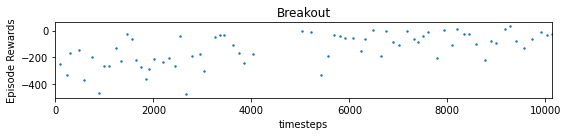

In [9]:
from rl_baselines import results_plotter
%matplotlib inline
results_plotter.plot_results(["./tmp/gym/trpo/openai-2020-07-11-04-47-01-182228"], 10e6, results_plotter.X_TIMESTEPS, "Breakout")

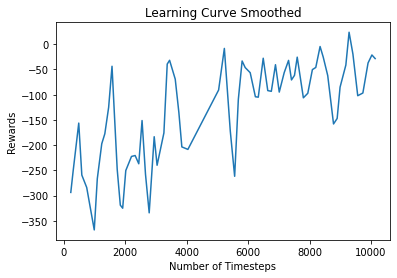

In [10]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=2)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

plot_results("./tmp/gym/trpo/openai-2020-07-11-04-47-01-182228")

In [11]:
base_dir = './tmp/gym/trpo'
log_dirs =  [os.path.join(base_dir,dI) for dI in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir,dI))]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
No handles with labels found to put in legend.


folder =  ./tmp/gym/trpo/openai-2020-07-11-04-47-01-182228
folder =  ./tmp/gym/trpo/openai-2020-07-11-05-23-17-330357
folder =  ./tmp/gym/trpo/openai-2020-07-11-06-21-02-139373
folder =  ./tmp/gym/trpo/openai-2020-07-11-06-24-37-827162


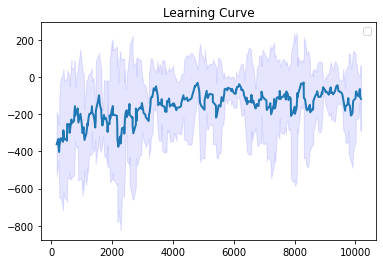

In [12]:
results_plotter.mean_std_plot(log_dirs, is_smooth=False)

In [6]:
 import tensorflow as tf
 flat_tangent = tf.placeholder(dtype=tf.float32, shape=[None], name="flat_tan")

In [7]:
flat_tangent[0:6]

<tf.Tensor 'strided_slice:0' shape=(?,) dtype=float32>

In [8]:
flat_tangent.shape

TensorShape([Dimension(None)])

In [9]:
s = tf.reshape(flat_tangent[0: 6], shape)

NameError: ignored